In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import gzip
from Bio import SeqIO
import itertools
from Bio.Seq import Seq

### Calculation the average length of the enhancer

In [27]:
df_positive = pd.read_csv('GM12878.bed', header=None, sep="\t")

In [28]:
def preprocess_sets(df, label):
    df.rename(columns ={df.columns[0] : "ID", df.columns[1]: 'first', df.columns[2] :'last'}, inplace=True)
    df = df.loc[~df.ID.isin(['chrM', 'chrX', 'chrY'])].copy()
    df['label'] = label
    return df

In [29]:
df_positive = preprocess_sets(df_positive, True)
df_positive.drop(df_positive.columns[3], axis = 1, inplace=True)
df_positive['length'] = df_positive['last']-df_positive['first']+1
df_positive

,ID,first,last,label,length
0,chr1,773300,774100,True,801
1,chr1,778980,779450,True,471
2,chr1,800100,802000,True,1901
3,chr1,825670,826410,True,741
4,chr1,839470,842590,True,3121
...,...,...,...,...,...
48555,chr9,140651150,140652330,True,1181
48556,chr9,140702130,140703100,True,971
48557,chr9,140703310,140704120,True,811
48558,chr9,140710520,140711890,True,1371


In [30]:
df_positive.loc[:, 'length'].mean()

1745.0801070840198

#### The average length rounded to 100 is 1700

In [31]:
mean_val  = 1700

### Predictions for each window

In [3]:
# Fasta file
df_fasta = pd.DataFrame(columns=['ID', 'sequence'])
with gzip.open("GRCh37.primary_assembly.genome.fa.gz", "rt") as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        identifier = record.id
        sequence = record.seq
        df_fasta = pd.concat([df_fasta, pd.DataFrame.from_records([{'ID':identifier, 'sequence':sequence}])], ignore_index=True)
df_fasta.drop(df_fasta[(df_fasta.ID.str.startswith('GL')) | (df_fasta.ID.isin(['chrM', 'chrX', 'chrY'])) ].index, inplace=True)
df_fasta.set_index('ID', inplace=True)

In [5]:
df_train = pd.read_csv('df_train_4mers.csv', index_col=0)
df_test = pd.read_csv('df_test_4mers.csv', index_col=0)

In [9]:
X_test = df_test.loc[:, df_test.columns != 'label'].copy()
y_test = df_test['label'].to_numpy()

X_train = df_train.loc[:, df_train.columns != 'label'].copy()
y_train = df_train['label'].to_numpy()

In [108]:
model_abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=4),n_estimators=200,learning_rate=0.2)
model_abc.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_split=4),
                   learning_rate=0.2, n_estimators=200)

In [10]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [105]:
print(f"Accuracy score: {accuracy_score(y_test, model.predict(X_test))}")
print(f"Precision score: {precision_score(y_test, model.predict(X_test), average='binary')}")

Accuracy score: 0.7130859673232555
Precision score: 0.665274246276789


### Preparing function for data transformation

In [11]:
def get_unique_kmers(k):
    letters = ["C", "A", "T", "G"]
    combinations_str = [''.join(i) for i in itertools.product(letters, repeat = k)]
    combinations = [Seq(mer) for mer in combinations_str]
    unique_kmers = []
    [unique_kmers.append(x) for x in combinations if x not in unique_kmers and x.reverse_complement() not in unique_kmers]
    unique_kmers = dict.fromkeys(unique_kmers, 0)
    return unique_kmers

In [12]:
unique_kmers = get_unique_kmers(4)

In [13]:
def replace_with_mean(x):
    k=0
    m=0
    for i in x:
        if i >= 0 :
            k+=i
            m+=1
    mean = k/m        
    for i in range(len(x)):
        if x[i] == -1:
            x[i] = mean
    return x

In [84]:
def count_prediction(model, sequence, unique_kmers, k):
    unique_kmers_str = [str(mer) for mer in unique_kmers]
    prob = []
    l = len(sequence)
    p = l // 1700
    for i in range(p+1):
        frequency = []    
        if i == p : 
            seq = sequence[p*1700 : l]
        else:
            seq = sequence[i*1700 : (i*1700 + 1700)]
        if seq.count("N")/len(seq) < 0.05:
        
            kmers_in_seq = len(seq) - k + 1

            for kmer in unique_kmers:
                kmer_rc = kmer.reverse_complement()
                if str(kmer) == str(kmer_rc):
                    count = seq.count_overlap(kmer)
                else:
                    count = seq.count_overlap(kmer) + seq.count_overlap(kmer_rc)
                frequency.append(count / kmers_in_seq) 
            data = pd.DataFrame(frequency).T
            data.columns = unique_kmers_str
            prob.append(model.predict_proba(data)[0,1])
        else :
            prob.append(-1)
    prob = replace_with_mean(prob)
    prob = [round(elem*100, 1) for elem in prob ]
    return prob         

### Comparison of the XGBoost and AdaBoost models

Although we chose the AdaBoost model in the previous stage, finally we decided to use the XGBoost model to visualize the prediction. We noted that the AdaBoost model classified the sequences as enhancer with at most 60% probability. With the XGBoost model, these results were more varied what can be seen in the plots below.

In [106]:
print(f"Accuracy score for XGBoost: {accuracy_score(y_test, model.predict(X_test))}")
print(f"Precision score for XGBoost: {precision_score(y_test, model.predict(X_test), average='binary')}")

Accuracy score for XGBoost: 0.7130859673232555
Precision score for XGBoost: 0.665274246276789


In [85]:
bb = df_fasta.loc['chr1', 'sequence']
pp = count_prediction(model, bb, unique_kmers, 4)

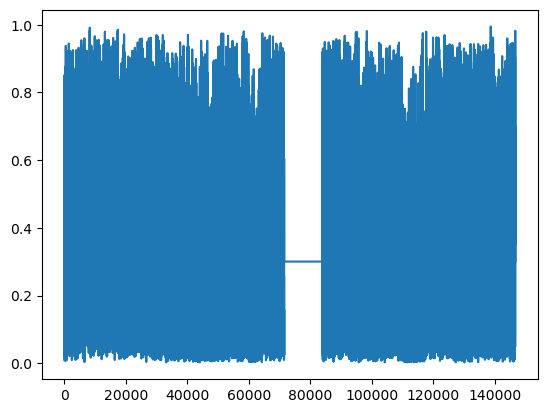

In [104]:
from matplotlib import pyplot as plt
plt.plot(pp)

In [109]:
print(f"Accuracy score for AdaBoost: {accuracy_score(y_test, model_abc.predict(X_test))}")
print(f"Precision score for AdaBoost: {precision_score(y_test, model_abc.predict(X_test), average='binary')}")

Accuracy score for AdaBoost: 0.7184811930574643
Precision score for AdaBoost: 0.6871356393315197


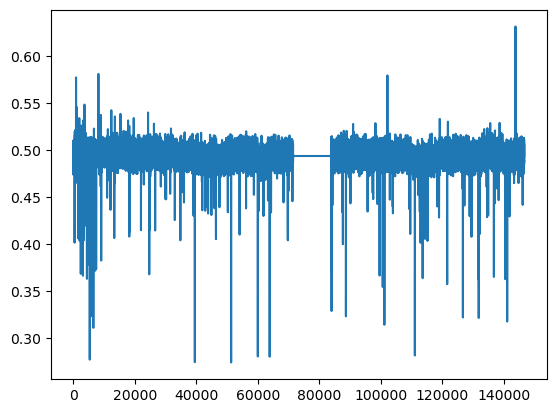

In [90]:
warnings.filterwarnings('ignore')
prob12 = count_prediction(model_abc, chr1, unique_kmers, 4)
plt.plot(prob12)

### Preparing and saving the data
Calculating the prediction for each window of 1700 nucleotides in each chromosom.

In [104]:
list = ['chr1','chr2', 'chr3', 'chr4', 'chr5', 'chr6','chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12','chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
warnings.filterwarnings('ignore')
for x in list:
    chrr = df_fasta.loc[x, 'sequence']
    prob = count_prediction(model, chrr, unique_kmers, 4)
    np.save(x, prob)
    print(f"plik: {x} został zapisany")

plik: chr2 został zapisany
plik: chr3 został zapisany
plik: chr4 został zapisany
plik: chr5 został zapisany
plik: chr6 został zapisany
plik: chr7 został zapisany
plik: chr8 został zapisany
plik: chr9 został zapisany
plik: chr10 został zapisany
plik: chr11 został zapisany
plik: chr12 został zapisany
plik: chr13 został zapisany
plik: chr14 został zapisany
plik: chr15 został zapisany
plik: chr16 został zapisany
plik: chr17 został zapisany
plik: chr18 został zapisany
plik: chr19 został zapisany
plik: chr20 został zapisany
plik: chr21 został zapisany
plik: chr22 został zapisany


#### Data loading

In [122]:
tab_of_chromosoms = []
for x in list:
    exec(f"{x} = np.load(x+'.npy').tolist()")